In [1]:
# !sudo apt-get update
# !sudo apt-get install -y xvfb python3-opengl
# !pip install pyvirtualdisplay
# !pip install gym[classic_control]

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

from IPython import display
# from pyvirtualdisplay import Display
# d = Display(visible=0, size=(400, 300))
# d.start()

def show_state(env, episode=0, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render())#mode='rgb_array'))
    plt.title("%s | Eposide: %d | Step: %d %s" % ('Cart-pole-v1', episode, step, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())

In [3]:
# import copy
import torch
from torch import distributions
# from torch.autograd import Variable
from torch.optim.lr_scheduler import StepLR
# import random
# import math
# import torchvision.transforms as T
import numpy as np
# import time
# import gym, math
import gymnasium as gym
from scipy.signal import lfilter

##Классы и функции

Честно взято отсюда: https://github.com/openai/spinningup/blob/master/spinup/algos/pytorch/ppo/core.py

In [4]:
# Чтобы не прописывать все слои сети руками
def mlp(sizes, activation, output_activation=torch.nn.Identity):
    layers = []
    for j in range(len(sizes)-1):
        act = activation if j < len(sizes)-2 else output_activation
        layers += [torch.nn.Linear(sizes[j], sizes[j+1]), act()]
    return torch.nn.Sequential(*layers)

# Для подсчета массива ожидаемых суммарных
# вознаграждений с дисконтированием по массиву наград
def discount_cumsum(x, discount):
  return lfilter(
      b=[1],
      a=[1, float(-discount)],
      x=x[::-1],
      axis=0)[::-1]

# # Агент, который еще только учится
# class MLPCategoricalActor(torch.nn.Module):
#     def __init__(self, obs_dim, act_dim, hidden_sizes, activation):
#         super().__init__()
#         self.logits_net = mlp([obs_dim] + list(hidden_sizes) + [act_dim], activation)

#     def get_policy(self, obs):
#         logits = self.logits_net(obs)
#         return distributions.Categorical(logits=logits)

#     def _log_prob_from_distribution(self, pi, act):
#         return pi.log_prob(act)

#     def forward(self, obs, act=None):
#         # Produce action distributions for given observations, and
#         # optionally compute the log likelihood of given actions under
#         # those distributions.
#         pi = self.get_policy(obs)
#         logp_a = None
#         if act is not None:
#             logp_a = self._log_prob_from_distribution(pi, act)
#         return pi, logp_a

# Агент, который еще только учится
class MLPGaussianActor(torch.nn.Module):
    def __init__(self, obs_dim, act_dim, hidden_sizes, activation):
        super().__init__()
        log_std = -0.5 * np.ones(act_dim, dtype=np.float32)
        self.log_std = torch.nn.Parameter(torch.as_tensor(log_std))
        self.mu_net = mlp([obs_dim] + list(hidden_sizes) + [act_dim], activation)

    def get_policy(self, obs):
        mu = self.mu_net(obs)
        std = torch.exp(self.log_std)
        return distributions.Normal(mu, std)

    def _log_prob_from_distribution(self, pi, act):
        return pi.log_prob(act).sum(axis=-1)    # Last axis sum needed for Torch Normal distribution
    
    def forward(self, obs, act=None):
        # Produce action distributions for given observations, and
        # optionally compute the log likelihood of given actions under
        # those distributions.
        pi = self.get_policy(obs)
        logp_a = None
        if act is not None:
            logp_a = self._log_prob_from_distribution(pi, act)
        return pi, logp_a

# Начинающий оценщик V-функции
class MLPCritic(torch.nn.Module):

    def __init__(self, obs_dim, hidden_sizes, activation):
        super().__init__()
        self.v_net = mlp([obs_dim] + list(hidden_sizes) + [1], activation)

    def forward(self, obs):
        return torch.squeeze(self.v_net(obs), -1) # Critical to ensure v has right shape.

In [24]:
from gymnasium.spaces import Box, Discrete

class PPOac(torch.nn.Module):
    def __init__(self, observation_space, action_space, hidden_dim=12, pi_lr=3e-4, vf_lr=1e-3, train_pi_iters=5, train_v_iters=5, target_kl=0.01, clip_ratio=0.2):
        super().__init__()

        activation = torch.nn.Tanh
        # activation = torch.nn.LeakyReLU()
        hidden_sizes = [hidden_dim] * 2

        if isinstance(action_space, Box):
            self.pi = MLPGaussianActor(observation_space.shape[0], action_space.shape[0], hidden_sizes, activation)
        elif isinstance(action_space, Discrete):
            # self.pi = MLPCategoricalActor(state_dim, action_dim, hidden_sizes, activation)
            raise ValueError('Are you sure you want discrete action space?')
        else:
            raise ValueError('What the heck is this action space?')

        # build value function
        self.v  = MLPCritic(observation_space.shape[0], hidden_sizes, activation)

        self.pi_optimizer = torch.optim.Adam(self.pi.parameters(), lr=pi_lr)
        self.vf_optimizer = torch.optim.Adam(self.v.parameters(), lr=vf_lr)
        self.train_pi_iters = train_pi_iters
        self.train_v_iters = train_v_iters
        self.target_kl = target_kl
        self.clip_ratio = clip_ratio

    def get_action(self, state):
        with torch.no_grad():
            obs = torch.as_tensor(state, dtype=torch.float32)
            pi = self.pi.get_policy(obs)
            a = pi.sample()
            logp_a = self.pi._log_prob_from_distribution(pi, a)
            v = self.v(obs)
        return a.numpy(), v.numpy(), logp_a.numpy()

    # def act(self, obs):
        #     return self.step(obs)[0]

    # Set up function for computing PPO policy loss
    def compute_loss_pi(self, obs, act, adv, logp_old):
        # obs, act, adv, logp_old = data['obs'], data['act'], data['adv'], data['logp']

        # Policy loss
        pi, logp = self.pi(obs, act)
        ratio = torch.exp(logp - logp_old)
        clip_adv = torch.clamp(ratio, 1 - self.clip_ratio, 1 + self.clip_ratio) * adv
        loss_pi = -(torch.min(ratio * adv, clip_adv)).mean()

        # # Useful extra info
        # approx_kl = (logp_old - logp).mean().item()
        # ent = pi.entropy().mean().item()
        # clipped = ratio.gt(1 + clip_ratio) | ratio.lt(1 - clip_ratio)
        # clipfrac = torch.as_tensor(clipped, dtype=torch.float32).mean().item()
        # pi_info = dict(kl=approx_kl, ent=ent, cf=clipfrac)

        approx_kl = (logp_old - logp).mean().item()
        pi_info = dict(kl=approx_kl)

        return loss_pi, pi_info

    # Set up function for computing value loss
    def compute_loss_v(self, obs, ret):
        # obs, ret = data['obs'], data['ret']
        return ((self.v(obs) - ret) ** 2).mean()

    def update(self, obs, batch_actions, adv, logp_old, ret):
        # data = buf.get()
        obs = torch.as_tensor(obs, dtype=torch.float32)
        act = torch.as_tensor(batch_actions, dtype=torch.float32)
        # torch.FloatTensor(
        adv = torch.as_tensor(adv, dtype=torch.float32)
        logp_old = torch.as_tensor(logp_old, dtype=torch.float32)
        ret = torch.as_tensor(ret, dtype=torch.float32)


        pi_l_old, pi_info_old = self.compute_loss_pi(obs, act, adv, logp_old)
        pi_l_old = pi_l_old.item()
        v_l_old = self.compute_loss_v(obs, ret).item()

        # Train policy with multiple steps of gradient descent
        for i in range(self.train_pi_iters):
            self.pi_optimizer.zero_grad()
            loss_pi, pi_info = self.compute_loss_pi(obs, act, adv, logp_old)
            # kl = mpi_avg(pi_info['kl'])
            kl = pi_info['kl']
            if kl > 1.5 * self.target_kl:
                # logger.log('Early stopping at step %d due to reaching max kl.' % i)
                break
            loss_pi.backward()
            # mpi_avg_grads(ac.pi)  # average grads across MPI processes
            self.pi_optimizer.step()

        # logger.store(StopIter=i)

        # Value function learning
        for i in range(self.train_v_iters):
            self.vf_optimizer.zero_grad()
            loss_v = self.compute_loss_v(obs, ret)
            loss_v.backward()
            # mpi_avg_grads(ac.v)  # average grads across MPI processes
            self.vf_optimizer.step()

        # Log changes from update
        # kl, ent, cf = pi_info['kl'], pi_info_old['ent'], pi_info['cf']
        # logger.store(LossPi=pi_l_old, LossV=v_l_old,
        #               KL=kl, Entropy=ent, ClipFrac=cf,
        #               DeltaLossPi=(loss_pi.item() - pi_l_old),
        #               DeltaLossV=(loss_v.item() - v_l_old))

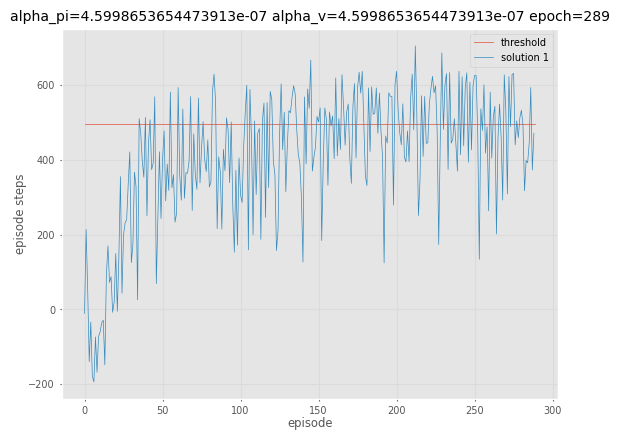

d:\Miniconda\envs\hex\lib\site-packages\glfw\__init__.py:917: GLFWError: (65537) b'The GLFW library is not initialized'
  warnings.warn(message, GLFWError)


KeyboardInterrupt: 

In [27]:

device = "cpu"
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

STEPS_MAX = 10000//2

from gymnasium.envs.registration import register
register(
    id="Hexapod-v0",
    entry_point="gym_env:HexapodEnv",
    max_episode_steps=STEPS_MAX,
    reward_threshold=3800.0,
)
env = gym.make('Hexapod-v0', render_mode='human',max_geom=7000)
# env = gym.make('CartPole-v1', render_mode='rgb_array')
# env = gym.make('CartPole-v1')
print('SHApes',env.observation_space.shape, env.action_space.shape)


#PPO

# Learning Parameters
alpha_pi = 0.01
alpha_v = 0.01
gsteps_pi = 20
gsteps_v = 20
gamma=0.99
lam = 0.95 # ЭТО lambda ДЛЯ ADVANTAGE

# Execution parameters
SHOW_ANIMATION = False
EPISODES_MAX = 500

DESIRED_STEPS = 250

# Loggers
log_steps_number = np.zeros(EPISODES_MAX)

# n_states = 4
# n_actions = 2
n_hidden = 70

agent = PPOac(env.observation_space, env.action_space, n_hidden, alpha_pi, alpha_v, gsteps_pi, gsteps_v)
scheduler_pi = StepLR(agent.pi_optimizer, step_size=10, gamma=0.7)
scheduler_v = StepLR(agent.vf_optimizer, step_size=10, gamma=0.7)

#data storage
batch_size = 1000

batch_states = []
batch_actions = []
batch_ret = []
batch_adv = []
batch_logps = []

epoch = 0

# PPO
for i_episode in range(EPISODES_MAX):
    episode_states = []
    episode_actions = []
    episode_rewards = []
    episode_total_return = 0
    episode_logps = []
    episode_vals = []
    episode_ret = []

    observation = env.reset()[0]
    state = observation

    # show results
    if (i_episode + 1) % 10 == 0:
        plt.figure(1)
        plt.clf()
        plt.plot([0,i_episode], [495, 495], label="threshold")
        plt.plot(range(0,i_episode), log_steps_number[0:i_episode], label="solution 1")
        plt.xlabel('episode')
        plt.ylabel('episode steps')
        plt.legend()
        plt.title('alpha_pi={} alpha_v={} epoch={}'.format(scheduler_pi.get_last_lr()[0],scheduler_v.get_last_lr()[0],epoch))
        display.clear_output(wait=True)
        plt.show()

    for t in range(STEPS_MAX):
        # if SHOW_ANIMATION or (i_episode > 0.9*EPISODES_MAX and t > 0.95*DESIRED_STEPS):
        #     print(i_episode, 0.9*EPISODES_MAX, 0.95*DESIRED_STEPS)
        #     # show_state(env.env, i_episode, t)
        #     # env.render()
        if (i_episode+1)%50 == 0 and i_episode > 0.5*EPISODES_MAX and t > DESIRED_STEPS and i_episode+1 != EPISODES_MAX:
            # print(i_episode, 0.9*EPISODES_MAX, 0.95*DESIRED_STEPS)
            # show_state(env.env, i_episode, t)
            # env.render()
            pass


        action, v, logp = agent.get_action(state)
        # print(action,v,logp)
        action = action.tolist()
        logp = logp.tolist()

        observation, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        episode_total_return += reward
        episode_states.append(state)
        episode_actions.append(action)
        episode_rewards.append(reward)
        episode_logps.append(logp)
        episode_vals.append(v)

        state = observation

        if done:
            log_steps_number[i_episode] = episode_total_return;

            last_val = 0
            episode_ended = t == STEPS_MAX - 1
            if episode_ended:
              _, last_val, _ = agent.get_action(state)
            rews = np.append(episode_rewards, last_val)
            vals = np.append(episode_vals, last_val)
            # the next two lines implement GAE-Lambda advantage calculation
            deltas = rews[:-1] + gamma * vals[1:] - vals[:-1]
            episode_adv = discount_cumsum(deltas, gamma * lam).tolist()
            # the next line computes rewards-to-go, to be targets for the value function
            episode_ret = discount_cumsum(rews, gamma)[:-1].tolist()

            batch_states += episode_states
            batch_actions += episode_actions
            batch_logps += episode_logps
            batch_adv += episode_adv
            batch_ret += episode_ret


            if len(batch_states) >= batch_size:
              agent.update(batch_states, batch_actions, batch_adv, batch_logps, batch_ret)

              epoch += 1
              batch_states = []
              batch_actions = []
              batch_logps = []
              batch_adv = []
              batch_ret = []

              scheduler_pi.step()
              scheduler_v.step()

            break

print("done")
path_weights = 'hex.weights'
torch.save(agent.state_dict(), path_weights)


In [ ]:
plt.figure(1)
plt.clf()
plt.plot([0,i_episode], [1.76*300, 1.76*300], label="threshold")
plt.plot(range(0,i_episode), log_steps_number[0:i_episode], label="solution 1")
plt.xlabel('episode')
plt.ylabel('episode steps')
plt.legend()
plt.title('alpha_pi={} alpha_v={} epoch={}'.format(scheduler_pi.get_last_lr()[0],scheduler_v.get_last_lr()[0],epoch))
display.clear_output(wait=True)
plt.show()

##Проверка

In [28]:
path_weights = 'hex_best_120.weights'
torch.save(agent.state_dict(), path_weights)

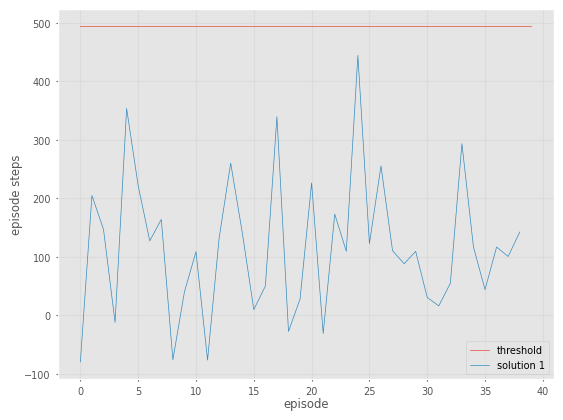

d:\Miniconda\envs\hex\lib\site-packages\glfw\__init__.py:917: GLFWError: (65537) b'The GLFW library is not initialized'
  warnings.warn(message, GLFWError)


done


In [23]:
# env = gym.make('CartPole-v1')
# env = gym.make('CartPole-v1', render_mode='rgb_array')
env = gym.make('Hexapod-v0', render_mode='human', max_geom=7000)

# Execution parameters
SHOW_ANIMATION = False
EPISODES_MAX = 50
STEPS_MAX = 10000//2

# Loggers
log_steps_number = np.zeros(EPISODES_MAX)

# PQ
for i_episode in range(EPISODES_MAX):
    observation = env.reset()[0]
    state = observation
    episode_total_return = 0
    
    # show results
    if (i_episode + 1) % 20 == 0:
        plt.figure(1)
        plt.clf()
        plt.plot([0,i_episode], [495, 495], label="threshold")
        plt.plot(range(0,i_episode), log_steps_number[0:i_episode], label="solution 1")
        plt.xlabel('episode')
        plt.ylabel('episode steps')
        plt.legend()
        display.clear_output(wait=True)
        plt.show()
    
    for t in range(STEPS_MAX):
        action, _, _ = agent.get_action(state)
        observation, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        state = observation
        episode_total_return += reward

        if done:
            log_steps_number[i_episode] = episode_total_return;
            break

print("done")

Загрузка весов обученной модели

In [8]:
#Later to restore:
new_agent = PPOac(env.observation_space, env.action_space, n_hidden)
new_agent.load_state_dict(torch.load(path_weights))
new_agent.eval()

C:\Users\Danielf\AppData\Local\Temp\ipykernel_23280\1149551841.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  new_agent.load_state_dict(torch.load(path_weights))


PPOac(
  (pi): MLPGaussianActor(
    (mu_net): Sequential(
      (0): Linear(in_features=60, out_features=10, bias=True)
      (1): Tanh()
      (2): Linear(in_features=10, out_features=24, bias=True)
      (3): Identity()
    )
  )
  (v): MLPCritic(
    (v_net): Sequential(
      (0): Linear(in_features=60, out_features=10, bias=True)
      (1): Tanh()
      (2): Linear(in_features=10, out_features=1, bias=True)
      (3): Identity()
    )
  )
)

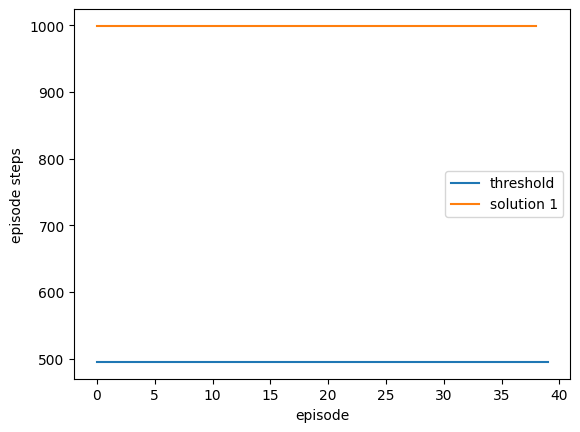

done


In [9]:
env = gym.make('Hexapod-v0', render_mode='rgb_array')

# Execution parameters
SHOW_ANIMATION = False
EPISODES_MAX = 40
STEPS_MAX = 1000

# Loggers
log_steps_number = np.zeros(EPISODES_MAX)

# PQ
for i_episode in range(EPISODES_MAX):
    observation = env.reset()[0]
    state = observation

    # show results
    if (i_episode + 1) % 20 == 0:
        plt.figure(1)
        plt.clf()
        plt.plot([0,i_episode], [495, 495], label="threshold")
        plt.plot(range(0,i_episode), log_steps_number[0:i_episode], label="solution 1")
        plt.xlabel('episode')
        plt.ylabel('episode steps')
        plt.legend()
        display.clear_output(wait=True)
        plt.show()

    for t in range(STEPS_MAX):
        action, _, _ = new_agent.get_action(state)
        observation, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        state = observation

        if done:
            log_steps_number[i_episode] = t;
            break

print("done")